# Анализ результатов A/B-теста

# Оглавление

1) [Введение](#header_1)

1.1 [Описание проекта](#header_2)

1.2 [Описание данных](#header_3)

2) [Предобработка данных](#header_4)

2.1 [Изменение названий столбцов](#header_5)

2.2 [Поиск и обработка дубликатов](#header_6)

2.3 [Приведение данных к нужному типу](#header_7)

2.4 [Поиск и обработка дубликатов](#header_8)

3) [Приоритезация гипотез](#header_9)

3.1 [Приоритезация гипотез с помощью фреймворка ICE](#header_10)

3.2 [Приоритезация гипотез с помощью фреймворка RICE](#header_11)

4) [Анализ A/B-теста](#header_12)

4.1 [Анализ графиков по кумулятивным показателям и относительным различиям. Неочищенные данные](#header_13)

4.2 [Поиск выбросов и аномалий](#header_14)

4.3 [Расчет статистической значимости разницы в среднем количестве заказов по неочищенным данным](#header_14)

4.4 [Расчет статистической значимости разницы в среднем чеке в разных группах теста по неочищенным данным](#header_15)

4.5 [Очищение данных от выбросов и аномалий](#header_16)

4.6 [Подсчет статистической значимости различий в конверсиях в заказ между группами по очищенным данным](#header_17)

4.7 [Подсчет статистической значимости различий в среднем чеке между сегментами по "очищенным" данным](#header_18)

5) [Выводы по проведенному исследованию](#header_19)

6) [Рекомендации по результатам А-В теста](#header_20)

## Введение
<a id='header_1'></a>

### Описание проекта
<a id='header_2'></a>

**Данный проект посвящен приоритезации гипотез, предложенных отделом маркетинга крупного интернет-магазина, а также анализу проведенного A/B-теста и его результатов.**

**Целью исследования является понимание, существует ли статистически значимый эффект от предложенного в гипотезе нововведения, другими словами - наблюдается ли статистически значимая разница между показателями двух групп теста. Результаты теста позволят компании принять решение, расширять ли нововведение на всех пользователей или нет.**

Исследование будет строится на основе нескольких датасетов. Во-первых, мы будем работать со списком перспективных гипотез, а также ранее рассчитанными параметрами, которые необходимы для приоритезации проверки гипотез. Во-вторых, нам доступны данные уже запущенного теста - информация о количестве пользователей из групп А и В и их покупках.

В нашем распоряжении есть 3 датасета:

**Датасет с гипотезами со следующими параметрами:**

- Hypothesis — краткое описание гипотезы,

- Reach — охват пользователей по 10-балльной шкале,

- Impact — влияние на пользователей по 10-балльной шкале,

- Confidence — уверенность в гипотезе по 10-балльной шкале,

- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Этот параметр отображает, насколько дорого обойдется проверка гипотезы.

**Датасет с заказами пользователей:**

- transactionId — идентификатор заказа,

- visitorId — идентификатор пользователя, совершившего заказ,

- date — дата, когда был совершён заказ,

- revenue — выручка заказа,

- group — группа A/B-теста, в которую попал заказ.

**Датасет с информацией о количестве пользователей:**

- date — дата,

- group — группа A/B-теста,

- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.


### Описание данных
<a id='header_3'></a>

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import datetime as dt
from pandas.plotting import register_matplotlib_converters
import warnings
import seaborn as sns
import plotly.express as px

In [2]:
# загружаем данные для анализа и сохраняем их в переменные

hypothesis, orders, visitors = (
    pd.read_csv('/data/hypotesis.csv'),
    pd.read_csv('/data/order.csv'),
    pd.read_csv('/data/visit.csv'),
)

In [3]:
# знакомимся с данными файла, содержащего гипотезы

hypothesis.sample(2)

,Hypothesis,Reach,Impact,Confidence,Efforts
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
7,Добавить форму подписки на все основные страни...,10,7,8,5


In [4]:
# знакомимся с файлом, содержащим заказы

orders.head(2)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B


In [5]:
# и то же самое делаем с файлом, содержащим информацию о кол-ве пользователей

visitors.tail(2)

,date,group,visitors
60,2019-08-30,B,490
61,2019-08-31,B,718


In [6]:
# взглянем на общую информацию о первом из датасетов

hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [7]:
# теперь ознакомимся с информацией о втором из датасетов 

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
# то же самое для датасета с кол-вом пользователей, посетивших интернет-магазин

visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Исследование будет проводиться на основе трех датасетов: 
- с гипотезами и параметрами для выявления их приоритетности - hypothesis,
- с информацией о заказах пользователей из A/B-теста - orders,
- с информацией о количестве пользователей в каждую из дат проведения теста - visitors.

Размеры датасетов (количество строк и столбцов):

**hypothesis:** 9 строк и 5 столбцов

**orders:** 1197 строк и 5 столбцов

**visitors:** 62 строки и 3 столбца

Знакомство с данными позволило заметить проблемы, которые нужно будет устранить на этапе предобработки: в первую очередь это неправильный тип данных в столбцах с датой и временем. Также для удобства дальнейшей работы и устранения возможных неточностей переименуем название столбцов, чтобы они содержали только строчные символы и подчеркивания. Пропуски отсутствуют.


## Предобработка данных
<a id='header_4'></a>

### Изменения названия столбцов
<a id='header_5'></a>

In [9]:
# приведем к нижнему регистру названия столбцов, а также добавим нижнее подчеркивание между словами

hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={'transactionid':'transaction_id', 'visitorid':'visitor_id'})


In [10]:
# проверяем корректность изменений

display(hypothesis.head(2))
orders.head(2)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B


### Изменение типа данных
<a id='header_6'></a>

Проверим необходимость изменения типов данных в столбцах с датами: метод info() показал объект типа object, но таким образом могут обозначаться как реальные строки str, так и объекты datetime.date

In [11]:
pd.api.types.infer_dtype(orders['date'])

'string'

In [12]:
# изменим тип данных в столбцах с датой и временем и сразу проверим изменения

orders['date'] = pd.to_datetime(orders['date']).dt.date
pd.api.types.infer_dtype(orders['date'])

'date'

In [13]:
# то же самое делаем со столбцом, содержащим дату в другом датасете

pd.api.types.infer_dtype(visitors['date'])

'string'

In [14]:
visitors['date'] = pd.to_datetime(visitors['date']).dt.date
pd.api.types.infer_dtype(visitors['date'])

'date'

### Поиск и обработка дубликатов
<a id='header_7'></a>

In [15]:
# ищем явные дубликаты в датасете hypothesis 

hypothesis.duplicated().sum()

0

In [16]:
# ищем явные дубликаты в заказах

orders.duplicated().sum()

0

In [17]:
# ищем явные дубликаты в датасете с количетсвом пользователей

visitors.duplicated().sum()

0

Мы провели предобработку данных в рамках, которой были устранены следующие проблемы:

- все названия столбцов приведены к единому стилю
- изменен тип данных в столбцах с датой и временем

Пропуски и дубликаты не были обнаружены.

## Приоритезация гипотез
<a id='header_8'></a>

In [18]:
# для начала ознакомимся с гипотезами, выдвинутыми отделом маркетинга

for element in hypothesis['hypothesis']:
    print(element)


Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
Запустить собственную службу доставки, что сократит срок доставки заказов
Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар
Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей
Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов
Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
Запустить акцию, дающую скидку на товар в день рождения


### Приоритезация гипотез с помощью фреймворка ICE
<a id='header_9'></a>

**Фреймворк ICE используется для приоритезации гипотез. Он включает в себя несколько факторов, которые помогают в выборе объективной оценки.**

**Impact - оценивает влияние нововведения на пользователя или ключевой показатель**

**Efforts - усилия, необходимые для реализации нововведения**

**Confidence - оценивает нашу уверенность в оценке влияния и усилий**

**ICE = (IMPACT * CONFIDENCE) / EFFORTS**

In [19]:
# рассчитаем ICE-score для предложенных девяти гипотез

pd.options.display.max_colwidth = 210
hypothesis['ICE'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(3)
hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


Метод приоритезации гипотез ICE в качестве наиболее перспективной выдвигает гипотезу, предполагающую запуск акции, дающей скидку на день родждения - ее ICE-score 16,2. Тройка лидеров выглядит следующим образом:

- гипотеза №8: Запустить акцию, дающую скидку на товар в день рождения
- гипотеза №0: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- гипотеза №7: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

###  Приоритезация гипотез с помощью фреймворка RICE
<a id='header_10'></a>

**Фреймворк для приоритезации гипотез RICE опирается на ICE, но учитывает также дополнительный параметр - reach.**

**Reach - охват, то есть количество пользователей, которых затронет нововведение.**

**RICE = (REACH * IMPACT * CONFIDENCE) / EFFORTS**

In [20]:
# теперь используем другой метод приоритезации гипотез - RICE, он также позволит учесть охват изменений

pd.options.display.max_colwidth = 210
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values('RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Приоритезация методом RICE заметно изменила картину, благодаря параметру reach, который оценивает, на какое количество пользователей окажет влияние предлагаемое изменение. В топ-2 входят гипотезы:

- гипотеза №7: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- гипотеза №2: Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

Третье место поделили гипотезы: 

- гипотеза №0: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- гипотеза №6: Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию


**Выводы по приоритезации на основе применения методов ICE и RICE**

Топ-3 наиболее приоритетных гипотез меняются в зависимости от используемого метода приоритезации. Это связано с наличием в фреймворке RICE дополнительного параметра reach, который оценивает охват. Лидирующая по ICE-score гипотеза №8, предлагающая запуск акции со скидкой на день рождения, получила низкий RICE, так как затрагивает небольшое количество пользователей - именинников. 

Чтобы внедряемые изменения были эффективными, советуем начать тестирование одной из следующих наиболее перспективных гипотез:

1) гипотеза №7: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

2) гипотеза №2: Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

3) гипотеза №0: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

## Анализ A/B-теста
<a id='header_11'></a>

### Анализ графиков по кумулятивным показателям и относительным различиям. Неочищенные данные
<a id='header_12'></a>

In [21]:
# построим график кумулятивной средней выручки по группам

dates_groups = orders[['date','group']].drop_duplicates().sort_values(by='date')
dates_groups.head(3)

,date,group
55,2019-08-01,A
66,2019-08-01,B
175,2019-08-02,A


In [22]:
# собираем таблицу с кумулятивными данными по заказам, пользователям и выручке

orders_aggregated = (
    dates_groups.apply(lambda x: orders[np.logical_and(orders['date']<=x['date'], orders['group']==x['group'])]
    .agg({'date':'max', 'group':'max', 'transaction_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'}), axis=1)
)
orders_aggregated.head(4)

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748


In [23]:
# собираем таблицу с кумулятивными данными по пользователям

visitors_aggregated = (
    dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date']<=x['date'], visitors['group']==x['group'])]
    .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis=1)               
)
visitors_aggregated.head(4)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294


In [24]:
# объедняем кумулятивные данные в одну таблицу: в ней будут дата, группа, кумулятивное кол-во заказов к этой дате,
# кумулятивное кол-во покупателей к этой дате, кумулятивная выручка, а также кумулятивное кол-во посетителей

cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date','group'])


In [25]:
# заменим названия нескольких столбцов на те, которые будут лучше отражать смысл агрегированных данных: 
# transaction_id на orders, а visitor_id на bayers

cumulative_data = cumulative_data.rename(columns={'transaction_id':'orders', 'visitor_id':'buyers'})
cumulative_data.head(1)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719


In [26]:
# сохраним отдельно данные с кумулятивным кол-вом заказов и кумулятивной выручкой в группе А

cumulative_revenue_a = cumulative_data.query('group=="A"')[['date', 'orders', 'revenue']]

In [27]:
# то же самое сделаем с группой B

cumulative_revenue_b = cumulative_data.query('group=="B"')[['date', 'orders','revenue']]

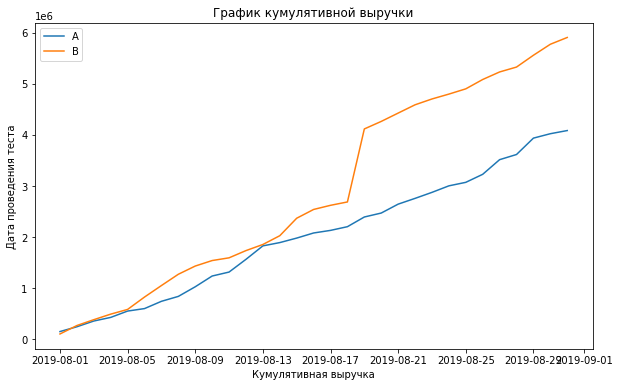

In [28]:
# строим графики кумулятивных выручек обеих групп

register_matplotlib_converters()

plt.figure(figsize=(10, 6)) 

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.xlabel('Кумулятивная выручка')
plt.ylabel('Дата проведения теста')
plt.legend()
plt.title('График кумулятивной выручки')
plt.legend() 
plt.show()

График кумулятивной выручки по обеим группам демонстрирует, что выручка росла на протяжении всего теста для обеих групп. В глаза бросается резкий скачок в группе В 19 августа. Это может быть связано, как с резким увеличением заказов в эту дату, так и с аномалией - нестандартно дорогими заказами. 

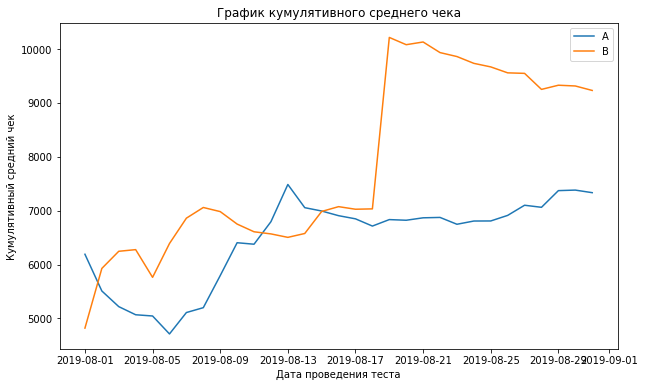

In [29]:
# построим графики кумулятивного среднего чека для обеих групп

plt.figure(figsize=(10, 6))

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label="A")
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label="B")
plt.xlabel('Дата проведения теста')
plt.ylabel('Кумулятивный средний чек')
plt.title('График кумулятивного среднего чека')
plt.legend()
plt.show()

Глядя на график можно сказать, что в группе B наблюдается резкий скачок в среднем чеке 19 августа, скачок в эту дату был заметен также на графике кумулятивной выручки. Судя по всему в этот день заказы были аномально дорогими, а, значит, рассматриваемому показателю в этой группе понадобится время и больше данных, чтобы стабилизироваться на уровне реального среднего чека. 

Средний чек группы A тоже быстро рос 8 по 13 апреля, однако этот рост был не таким кардинальным, как в группе B. Затем скачки сбавили амплитуду, но судя по графику средний чек группы А пока не стабилизировался окончательно. 

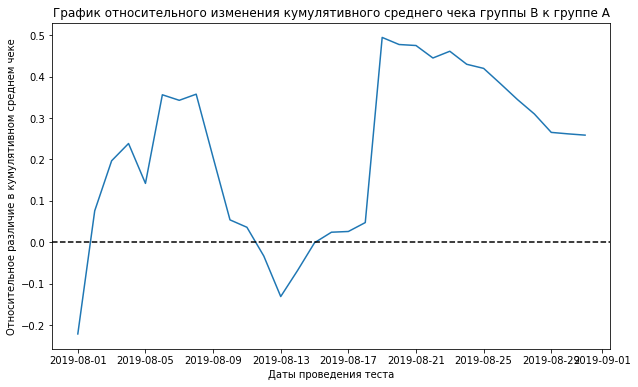

In [30]:
# построим график относительного изменения кумулятивного среднего чека группы B к группе A

merged_cumulative_revenue = (
    cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)

plt.figure(figsize=(10, 6))
plt.plot(
    merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']
    /merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA']) - 1)

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel('Относительное различие в кумулятивном среднем чеке')
plt.xlabel('Даты проведения теста')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Этот график хорошо показывает, как менялись различия в кумулятивном среднем чеке на протяжении проведения теста. В нескольких местах график достаточно резко скачет, это особенно заметно в начале теста, а также 10 и 19 августа: амплитуда этих скачков от 30 до 45%. 

Вначале средний чек группы B был на 20% ниже, чем в группе А, но всего за несколько дней ситуация изменилась. На протяжении 10 дней теста группа B лидировала по этому показателю с разницей почти в 40%, потом средний чек сегмента B снизился на 10% в сравнении с этим показателем в группе A, а 19 августа взлетел, после чего продолжил быть заметно больше, несмотря на начавшееся сразу после скачка снижение.

График говорит о том, что в данных вероятнее всего есть выбросы - очень дорогие заказы.

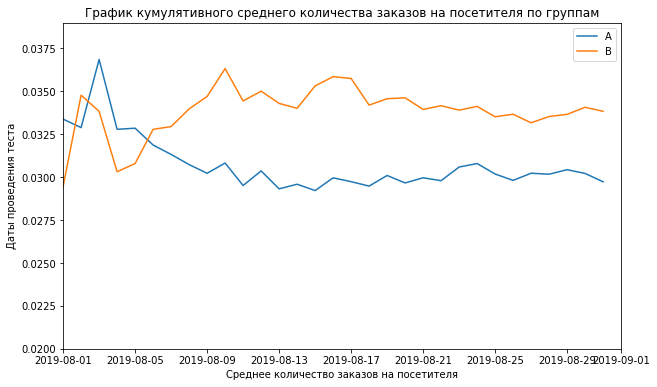

In [31]:
# построим график кумулятивного среднего количества заказов на посетителя(конверсии) по группам

cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

cumulative_data_a = cumulative_data.query('group=="A"')
cumulative_data_b = cumulative_data.query('group=="B"')

plt.figure(figsize=(10, 6))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label="A")
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label="B")
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Среднее количество заказов на посетителя')
plt.ylabel('Даты проведения теста')
plt.legend()
plt.axis(["2019-08-01", '2019-09-01', 0.02, 0.039])
plt.show()

В начале теста скачки в среднем количестве заказов на посетителя были резкими и встречались в обоих сегментах, что может быть связано, как с хорошей конверсией в покупку новых пользователей, так и с тем, что в тесте пристутствуют покупатели с нестандартным поведением - те, которые делают заказов больше, чем средний покупатель. При том в течение непродолжительного времени группа A лидировала по рассматриваемому показателю. Но приблизительно с конца первой недели теста группа B вырвалась вперед и сохранила свое положение. 

Конверсия из посетителей в заказы для группы A в начале теста была около 3,3%, затем ненадолго поднялась почти до 3,7%, но с этого момента преимущественно падает. К концу месяца она достигла примерно 3%. 

Этот показатель у группы B напротив в первые дни теста был значительно ниже - примерно 2,95%, затем заметно вырос и в последние 10 дней теста началось медленное снижение. К концу месяца кумулятивная конверсия из посетителей в заказы составила примерно 3,4%

Начиная со второй недели теста скачки также стали менее резкими, но все-таки к концу месяца стабилизация показателя не была достигнула полностью. 

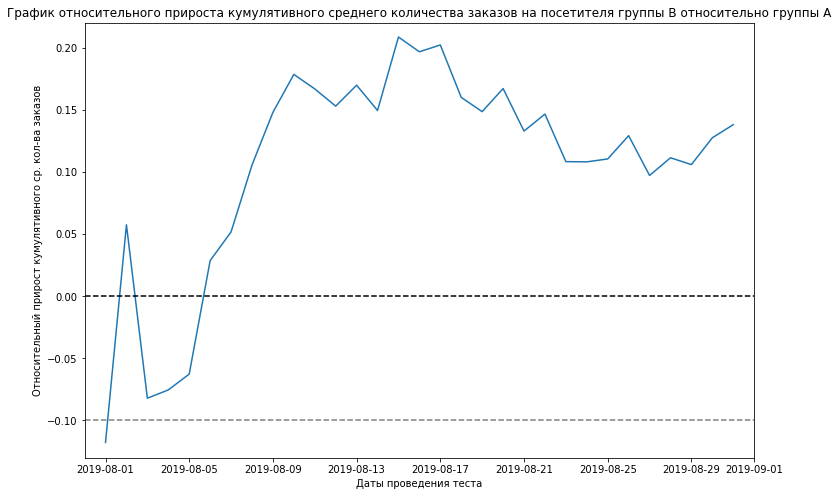

In [32]:
# построим график относительного изменения 
# кумулятивного среднего количества заказов на посетителя группы В к группе А

merged_cumulative_conversions = (
    cumulative_data_a[['date', 'conversion']]
    .merge(cumulative_data_b[['date', 'conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)
plt.figure(figsize=(12, 8))
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']
         /merged_cumulative_conversions['conversionA'] - 1)
plt.title('График относительного прироста кумулятивного среднего количества заказов на посетителя группы B относительно группы А')
plt.ylabel('Относительный прирост кумулятивного ср. кол-ва заказов')
plt.xlabel('Даты проведения теста')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis(["2019-07-31", '2019-09-01', -0.13, 0.22]) 
plt.show()

Этот график наглядно демонстрирует различие между кумулятивным средним в количестве заказов в разных сегментах теста, позволяет численно оценить относительную разницу, которая была заметна на предыдущем графике. 

В самом начале теста результаты группы B по среднему количеству заказов были меньше приблизительно на 12% относительно группы А, после этого последовало резкое колебание метрики вверх-вниз: результаты группы В сначала превзошли результаты второго сегмента, потом снова были ниже примерно на 8%. После этого разница в кумулятивном среднем количестве заказов на пользователя была в пользу сегмента В: на пике она достигла 20%, затем несколько снизилась, а в последние дни снова начала расти. По последним имеющимся данным относительная разница составляет около 14% в пользу группы В.

Судя по графику рассматриваемый показатель начал стабилизироваться примерно с 21 августа.

**Промежуточные выводы по анализу графиков кумулятивных метрик**

**Пока все графики демонстрируют превосходство группы В, как в среднем чеке, так и в количестве заказов. Но из-за вида графиков возникло предположение, что в данных есть аномалии**

На основании графиков кумулятивной выручки и кумулятивного среднего чека в изучаемых сегментах, возникло подозрение, что в данных могут присутствовать выбросы и аномалии. На обоих графиках присутствуют резкие скачки показателя, что вероятнее всего связано с нестандартным пользовательским поведением, которое может повредить достоверности статистического теста. Далее исследуем данные на предмет аномалий.

### Поиск выбросов и аномалий
<a id='header_13'></a>

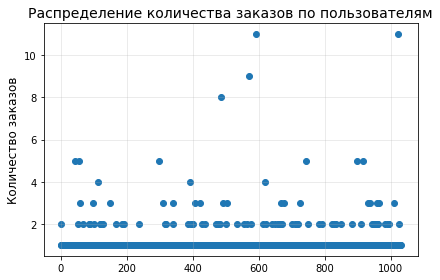

In [33]:
# построим точечный график количества заказов по пользователям

orders_by_buyers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id':'nunique'})
)

orders_by_buyers.columns = ['visitor_id', 'orders']
x_values = pd.Series(range(0, len(orders_by_buyers)))
plt.scatter(x_values, orders_by_buyers['orders'])

plt.title('Распределение количества заказов по пользователям', fontsize=14)
plt.ylabel('Количество заказов', fontsize=12)


plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

По этому графику отчетливно видно, что преимущественно, покупатели совершают одну покупку, реже две. Есть покупатели, которые не ограничиваются 1-2 покупками, но их немного. Можно увидеть совсем редкие случаи с 8, 9 и 11 заказами. 

Далее проверим сколько заказов совершают 95% и 99% всех пользователей. Это поможет установить границу для разграничения нормального и аномального количества заказов на 1 покупателя. 

In [34]:
# найдем 95 и 99 процентили в количестве заказов пользователей

percentile_95, percentile_99 = np.percentile(orders_by_buyers['orders'], [95, 99])

display(f'Не более 5% пользователей оформляли больше чем {percentile_95} заказов.')
f'Не более 1% пользователей оформляли больше чем {percentile_99} заказов.'

'Не более 5% пользователей оформляли больше чем 2.0 заказов.'

'Не более 1% пользователей оформляли больше чем 4.0 заказов.'

Выберем 2 заказа в качестве верхней допустимой границы для количества заказов на пользователя, так как таким образом мы сохраним большую часть данных, но избавимся от наиболее экстремальных значений.

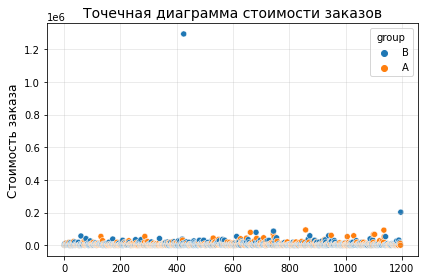

In [35]:
# посмотрим точечный график для стоимости заказов, но добавим цветовую кодировку, чтобы увидеть распределение стоимости заказов
# по группам теста

sns.scatterplot(data= orders, x=pd.Series(range(0, len(orders['revenue']))), y='revenue', hue="group")

plt.title('Точечная диаграмма стоимости заказов', fontsize=14)
plt.ylabel('Стоимость заказа', fontsize=12)

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


На графике видна общая масса заказов, которая вся сгруппировалась внизу и два отделившихся заказа, один из которых почти достиг "потолка" графика из-за своей стоимости в приблизительно 1 200 000 рублей. Это выброс.

**Точечная диаграмма с цветовой кодировкой разных групп теста позволила увидеть, что наиболее дорогие заказы были сделаны пользователями из группы В**

Посмотрим на распределение менее крупных заказов отдельно.

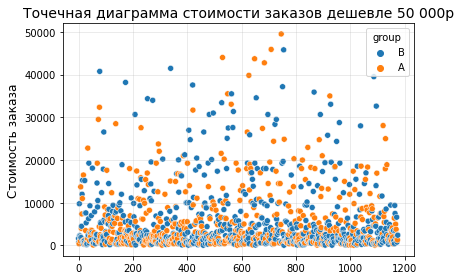

In [36]:
# сделаем срез из датасета orders с условием, что выручка с заказа не больше 50 000р, 
# чтобы посмотреть на распределение более мелких заказов

orders_slice = orders.query('revenue < 50000')
sns.scatterplot(data= orders_slice, x=pd.Series(range(0, len(orders_slice['revenue']))), y='revenue', hue="group")

plt.title('Точечная диаграмма стоимости заказов дешевле 50 000р', fontsize=14)
plt.ylabel('Стоимость заказа', fontsize=12)

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Этот график отчетливее показывает, что большая часть заказов находится в диапазоне от 0 до 5000 рублей. В данных периодически встречаются и более дорогие заказы, но их количество не так значительно. Судя по графику заказ стоимостью около 40 000 рублей уже можно считать редкостью.

Далее найдем 95 и 99 процентили, чтобы выбрать границу, по которой будем проводить чистку аномалий.

In [37]:
# найдем 95 и 99 процентили стоимости заказов

revenue_percentile_95, revenue_percentile_99 = np.percentile(orders['revenue'], [95, 99])
display(f'Не более 5% заказов дороже {revenue_percentile_95} рублей')
f'Не более 1% заказов дороже {revenue_percentile_99} рублей'

'Не более 5% заказов дороже 28000.000000000004 рублей'

'Не более 1% заказов дороже 58233.19999999999 рублей'

Пожалуй, откажемся от 5% данных, чтобы исключить аномально высокие значения стоимости заказов. 

### Расчет статистической значимости различий в среднем количестве заказов по неочищенным данным
<a id='header_14'></a>

Сформулируем нулевую и альтернативную гипотезы:

H0: среднее количество заказов в обеих группах одинаковое

H1: Среднее количество заказов в группах разное

Для того, чтобы применить стат-тест для определения статистически значимой разницы, необходимо подготовить данные к анализу. В подготовленную таблицу войдут данные, содержащие дату проведения теста, агрегированные данные на каждую дату теста, а также кумулятивные данные к каждой дате теста. 

Список столбцов, которые будут входить в таблицу:

- date — дата;
- orders_per_date_a — количество заказов в выбранную дату в группе A;
- revenue_per_date_a — суммарная выручка в выбранную дату в группе A;
- orders_per_date_b — количество заказов в выбранную дату в группе B;
- revenue_per_date_b — суммарная выручка в выбранную дату в группе B;
- orders_cumulative_a — суммарное число заказов до выбранной даты включительно в группе A;
- revenue_cumulative_a— суммарная выручка до выбранной даты включительно в группе A;
- orders_cumulative_b — суммарное количество заказов до выбранной даты включительно в группе B;
- revenue_cumulative_b — суммарная выручка до выбранной даты включительно в группе B;
- visitors_per_date_a — количество пользователей в выбранную дату в группе A;
- visitors_per_date_b — количество пользователей в выбранную дату в группе B;
- visitors_cumulative_a — количество пользователей до выбранной даты включительно в группе A;
- visitors_cumulative_b — количество пользователей до выбранной даты включительно в группе B.

In [38]:
# соберем таблицу data, которая будет содержать данные по обеим группам теста: агрегированные данные на конкретную 
# дату + кумулятивные данные

# делаем срез группы А из таблицы с посетителями 
visitors_a_daily = visitors.query('group=="A"')[['date','visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

# считаем кумулятивное количество посетителей в группе А
visitors_a_cumulative = (
    visitors_a_daily.apply(lambda x: visitors_a_daily[visitors_a_daily['date']<=x['date']]
    .agg({'date':'max', 'visitors_per_date_a':'sum'}), axis=1)
)
visitors_a_cumulative.columns = ['date', 'visitors_cumulative_a']

# делаем срез группы В из таблицы с посетителями
visitors_b_daily = visitors.query('group=="B"')[['date','visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

# считаем кумулятивное количество посетителей в группе В
visitors_b_cumulative = (
    visitors_b_daily.apply(lambda x: visitors_b_daily[visitors_b_daily['date']<=x['date']]
    .agg({'date':'max', 'visitors_per_date_b':'sum'}), axis=1)
)
visitors_b_cumulative.columns = ['date', 'visitors_cumulative_b']

# делаем срез группы А с данными о заказах и группируем их по дате теста. Считаем агрегированные заказы и выручку по дням
orders_a_daily = (
    orders.query('group=="A"')[['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id':pd.Series.nunique, 'revenue':'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

# считаем кумулятивные заказы и выручку для группы А
orders_a_cumulative = (
    orders_a_daily.apply(lambda x: orders_a_daily[orders_a_daily['date']<=x['date']]
    .agg({'date':'max', 'orders_per_date_a':'sum', 'revenue_per_date_a':'sum'}), axis=1)
    .sort_values(by=['date'])
)
orders_a_cumulative.columns = ['date', 'orders_cumulative_a', 'revenue_cumulative_a']

## делаем срез группы В с данными о заказах и группируем их по дате теста. Считаем агрегированные заказы и выручку по дням
orders_b_daily = (
    orders.query('group=="B"')[['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id':pd.Series.nunique, 'revenue':'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

# считаем кумулятивные заказы и выручку группы В
orders_b_cumulative = (
    orders_b_daily.apply(lambda x: orders_b_daily[orders_b_daily['date']<=x['date']]
    .agg({'date':'max', 'orders_per_date_b':'sum', 'revenue_per_date_b':'sum'}), axis=1)
    .sort_values(by=['date'])
)
orders_b_cumulative.columns = ['date', 'orders_cumulative_b', 'revenue_cumulative_b']

# собираем все рассчитанные данные в единую таблицу
data = (
    orders_a_daily.merge(orders_b_daily, left_on='date', right_on='date', how='left')
    .merge(orders_a_cumulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cumulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cumulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cumulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cumulative_a,revenue_cumulative_a,orders_cumulative_b,revenue_cumulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cumulative_a,visitors_cumulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Для того, чтобы вычислить статистически значимую разницу в среднем количестве заказов на посетителя между разными группами, необходимо создать две выборки с количеством заказов, которые сделали пользователи разных групп. 

In [39]:
# сгруппируем orders по visitor_id и посчитаем количество заказов за время теста для группы А

orders_by_visitors_a = (
    orders.query('group=="A"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id':pd.Series.nunique})
)
orders_by_visitors_a.columns = ['visitor_id', 'orders']
orders_by_visitors_a.head(2)

,visitor_id,orders
0,8300375,1
1,11685486,1


In [40]:
# сгруппируем orders по visitor_id и посчитаем количество заказов за время теста для группы B

orders_by_visitors_b = (
    orders.query('group=="B"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id':pd.Series.nunique})
)
orders_by_visitors_b.columns = ['visitor_id', 'orders']
orders_by_visitors_b.head(2)

,visitor_id,orders
0,5114589,1
1,6958315,1


In [41]:
# создадим две выборки sample_a и sample_b c количеством заказов всех пользователей по группам.
# для пользователей, не совершивших заказ, поставим нули

sample_a = (
    pd.concat([orders_by_visitors_a['orders'],
               pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_visitors_a['orders']))
                         , name='orders')],axis=0)
)

sample_b = (
    pd.concat([orders_by_visitors_b['orders'],
               pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_visitors_b['orders']))
                         , name='orders')],axis=0)
)

# ради интереса проверим, в какой группе присуствуют пользователи, которые совершали больше всего заказов
display(sample_b.value_counts())
sample_a.value_counts()

0    18330
1      552
2       23
3        5
4        4
5        1
6        1
Name: orders, dtype: int64

0    18233
1      473
2       17
3        7
4        3
5        2
7        1
Name: orders, dtype: int64

Случайным образом возникло предположение, что в переданном нам датасете с заказами пользлователей, присутствует проблемы с делением поьзователей на группы. На точечном графике, построенном сразу для всех пользователей, видны были выбросы с пользователями, совершившими 9-11 заказов за время теста. Однако максимальное количество заказов в получившихся у нас выборках соответствует 7. Возможно, один и тот же пользователь попал в обе группы. Проверим это.

In [42]:
# найдем пользователей, совершивших аномально большое количество заказов

orders_by_buyers.query('orders > 7')

,visitor_id,orders
487,2038680547,8
569,2378935119,9
591,2458001652,11
1023,4256040402,11


In [43]:
# проверим пользователя с id 2378935119. Не регистрировался ли он сразу в обеих группах?

orders.query('visitor_id==2378935119')

,transaction_id,visitor_id,date,revenue,group
33,486237576,2378935119,2019-08-15,1650,A
118,4233533907,2378935119,2019-08-22,3390,A
179,1784270968,2378935119,2019-08-17,310,A
391,2213813903,2378935119,2019-08-25,21220,B
435,2430683444,2378935119,2019-08-28,20450,B
473,3224706027,2378935119,2019-08-28,4410,B
697,1612868255,2378935119,2019-08-09,30649,B
1029,469609643,2378935119,2019-08-10,58220,A
1031,1661772358,2378935119,2019-08-10,2640,B


Видимо это так, у нас в датасете есть пользователи, которые участвовали в тесте сразу в обеих группах. Проверим, сколько таких пользователей

In [44]:
# посчитаем количество пользователей, которые присутствуют сразу в обеих группах теста

b_visitors = orders.query('group=="B"')['visitor_id'].unique()
a_visitors = orders.query('group=="A"')['visitor_id'].unique()

ab_visitors = np.intersect1d(a_visitors, b_visitors)
        
f'Количество пользователей, встречающихся сразу в обеих группах теста : {len(ab_visitors)}'

'Количество пользователей, встречающихся сразу в обеих группах теста : 58'

Наличие пользователей, которые участвуют сразу в обеих группах нарушает принципы проведения A/B-тестирования. 

Пока посчитаем статистическую значимость различий в среднем числе заказов на пользователя  по «сырым» данным — без удаления аномальных пользователей.

In [45]:
# применим статистический критерий Манна-Уитни для определения, есть ли статистически значимая разница в среднем 
# количестве заказов в группах теста

alpha = 0.05

p_value = st.mannwhitneyu(sample_a, sample_b)[1]

display("Значание p_value равно : {0:.3f}".format(p_value))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу, разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, не получилось обнаружить статистически значимых различий')
        

'Значание p_value равно : 0.017'

Отвергаем нулевую гипотезу, разница статистически значима


Получившееся значение p_value равно 0,017, что ниже принятого уровня статистической значимости 0,05. Значит, нулевую гипотезу о равенстве среднего количества заказов в группах А и В можно отвергнуть. Судя по всему наблюдаемая разница неслучайна. 

Проверим, каков относительный прирост среднего числа заказов группы В

In [46]:
# найдем относительный прирост среднего количества заказов пользователя группы В к группе А

f'Относительный прирост среднего количества заказов группы В составляет {(sample_b.mean()/sample_a.mean() - 1):.3f}'

'Относительный прирост среднего количества заказов группы В составляет 0.138'

Среднее количество заказов на пользователя у группы В больше на 13%.

### Расчет статистической значимости различий в среднем чеке в разных группах теста по неочищенным данным
<a id='header_15'></a>

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза H0: Средние чеки разных групп теста равны
- Альтернативная гипотеза H1: Средние чеки групп А и В отличаются

Уровень статистической значимости, необходимой для принятия решения об отвержении нулевой гипотезы, оставим равным 5%

In [47]:
# применим статистический критерий Манн-Уитни для определения, есть ли статистически значимая разница
# в средних чеках в разных группах теста

p_value_2 = st.mannwhitneyu(orders.query('group=="A"')['revenue'], orders.query('group=="B"')['revenue'])[1].round(3)

display(f'Значание p_value равно {p_value_2}')

if p_value_2 < alpha:
    print('Отвергаем нулевую гипотезу, разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о значимом различии сделать нельзя')
        
    

'Значание p_value равно 0.729'

Не получилось отвергнуть нулевую гипотезу, вывод о значимом различии сделать нельзя


Получившееся значение p_value превосходит принятый нами уровень стат значимости в 5%. Это значит, что имеющиеся у нас данные не дают оснований для того, чтобы отвергать нулевую гипотезу о равенстве средних чеков. 

Посмотрим на относительные различия в средних чеках между группами.

In [48]:
# найдем относительное различие в среднем чеке группы В к группе А

average_check_rise = (orders.query('group=="B"')['revenue'].mean()/orders.query('group=="A"')['revenue'].mean() - 1).round(3)
f'Относительный прирост среднего чека группы В к группе А: {average_check_rise}'

'Относительный прирост среднего чека группы В к группе А: 0.259'

Средний чек группы В больше примерно на 26%. Однако тест, проведенный с помощью критерия Манна-Уитни, продемонстрировал отсутствие статистически значимой разницы в средних чеках разных сегментов.

### Очищение данных от выбросов и аномалий
<a id='header_16'></a>

**Несмотря на то, что статистический критерий Манна-Уитни является ранговым и устойчив к отдельным выбросам, очистим данные от аномалий.**

На этапе изучения данных на предмет аномалий и выбросов мы нашли 95 процентили количества заказов и стоимости заказа - это 2 заказа и 28 000 рублей соответственно. Исключать из анализа будем пользователей:
- которые сделали более 2 заказов
- которые сделали заказ дороже 28 000 рублей

Также не будем забывать, что на этапе создания выборок для проведения теста, было обнаружено, что деление теста не сегменты А и В было нарушено. 58 пользователей оказались записаны сразу в оба сегмента. Удалим их, чтобы они не искажали результаты. 

Всех пользователей, которых выделим как "аномальных" объединим в единый датафрейм, чтобы не потерять и оценить какой объем данных исключаем их анализа.

In [49]:
# создадим датафрейм abnormal_visitors с пользователями, совершившими более 2 заказов, заказы на сумму более 2800 рублей
# или попали сразу в обе группы

max_revenue = int(np.percentile(orders['revenue'], [95]))
max_orders = int(np.percentile(orders_by_buyers['orders'], [95]))

visitors_with_many_orders = orders_by_buyers.query('orders > @max_orders')['visitor_id']

visitors_with_expansive_orders = orders.query('revenue > @max_revenue')['visitor_id']

ab_visitors = pd.Series(ab_visitors)

abnormal_visitors = (
    pd.concat([visitors_with_many_orders, visitors_with_expansive_orders, ab_visitors], axis=0)
    .drop_duplicates()
    .sort_values()
)
f'Количество аномальных пользователей: {len(abnormal_visitors)}'

'Количество аномальных пользователей: 113'

В общей массе пользователей, участвовавших в тесте, нашлось 113 пользователей с аномальным поведением. Исключим этих пользователей из дальнейшего вычисления статистически значимых различий в среднем количестве заказов и среднем чеке, так как они могли повлиять на результат теста.

In [50]:
# создадим очищенные выборки с количеством заказов по каждой группе теста

sample_a_filtered = pd.concat(
    [orders_by_visitors_a.query('visitor_id not in @abnormal_visitors')['orders'],
     pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_visitors_a['orders'])),
     name='orders')], axis=0
)

sample_b_filtered = pd.concat(
    [orders_by_visitors_b.query('visitor_id not in @abnormal_visitors')['orders'],
     pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_visitors_b['orders'])),
     name='orders')], axis=0
)


In [51]:
# проверяю, сколько удаленных пользователей в каждой группе

orders.query('visitor_id in @abnormal_visitors').groupby('group').agg({'visitor_id':'nunique'})

,visitor_id
group,
A,85
B,86


Данные были очищены от аномалий: 

- пользователей, которые совершали более 2 заказов
- пользователей, которые делали заказы на сумму, более 28 000 рублей
- пользователей, попавших сразу в обе группы теста

### Подсчет статистической значимости различий в конверсиях в заказ между группами по очищенным данным
<a id='header_17'></a>

Далее будем снова применять статистический критерий Манна-Уитни для определения статистической значимости различий, но на этот раз использовать его для очищенных данных. Определим, повлияли ли выбросы на результаты теста, или нет.

Нулевая и альтернативная гипотезы остаются прежними:

-  H0: Среднее количество заказов в разных группах теста равно
-  H1: Среднее количество заказов в группах А и В отличается

In [52]:
# применим статистический критерий Манн-Уитни для определения, имеется ли значимая разница в среднем количестве
# заказов на пользователя, т.е. конверсии, в разных сегментах теста

p_value_3 = st.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1].round(3)

display(f'Значание p_value равно : {p_value_3}')

if p_value_3 < alpha:
    print('Отвергаем нулевую гипотезу, разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, не получилось обнаружить статистически значимых различий')

'Значание p_value равно : 0.009'

Отвергаем нулевую гипотезу, разница статистически значима


Полученное значение p_value меньше уровня статистической значимости, что говорит о том, что нулевую гипотезу об отстутствии разницы в среднем количестве заказов между группами теста, необходимо отвергнуть в пользу альтернативной. 

Посчитаем относительный прирост среднего числа заказов в группе В.

In [53]:
# найдем относительный прирост среднего количества заказов группы В к группе А по очищенным данным

f'Относительный прирост среднего количества заказов группы В по очищенным данным составляет {(sample_b_filtered.mean()/sample_a_filtered.mean() - 1):.3f}'

'Относительный прирост среднего количества заказов группы В по очищенным данным составляет 0.189'

Среднее количество заказов на посетителя в группе В выше: относительное различие между сегментами по очищенным данным составляет около 19%.

Ранее мы проводили статистический тест на "сырых" данных. В целом, результаты теста не изменились после очищения данных от выбросов: нулевая гипотеза в обоих случаях была отвергнута в пользу альтернативной, а относительная разница дважды показывала лидирующее положение группы В по показателю средней конверсии пользователей в заказ. 

Результаты теста по "сырым" данным:
p_value - 0,017; относительный прирост в среднем количестве заказов в группе В - 0,138

Результаты теста по "очищенным" данным:
p_value - 0,009; относительный прирост в среднем количестве заказов в группе В - 0,189

### Подсчет статистической значимости различий в среднем чеке между сегментами по очищенным данным
<a id='header_18'></a>

Оставляем уже сформулированные ранее нулевую и альтернативную гипотезы:

- Нулевая гипотеза H0: Средние чеки разных групп теста равны
- Альтернативная гипотеза H1: Средние чеки групп А и В отличаются

На этот раз будем использовать критерий Манна-Уитни для данных, очищенных от выбросов. Посмотрим, как это повлияет на результаты теста. Рассчитаем также относительную разницу показателей для групп А и В.

In [54]:
# применим гритерий Манна-Уитни для определения, есть ли статистически значимая разница в среднем чеке разных групп
# пользователей после очистки данных

p_value_4 = (
    st.mannwhitneyu(orders.query('group=="A" and visitor_id not in @abnormal_visitors')['revenue'],
                    orders.query('group=="B" and visitor_id not in @abnormal_visitors')['revenue'])[1].round(3)
)

display(f'Значание p_value равно {p_value_4}')

if p_value_4 < alpha:
    print('Отвергаем нулевую гипотезу, разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о значимом различии сделать нельзя')

'Значание p_value равно 0.762'

Не получилось отвергнуть нулевую гипотезу, вывод о значимом различии сделать нельзя


Как и в случае с "сырыми" данными, мы получили p_value значительно превышающее уровень статистической значимости, что говорит о том, что мы не можем отвергнуть нулевую гипотезу: при условии, что нулевая гипотеза о равенстве средних чеков верна, наблюдаемые данные вполне вероятны.

Далее рассчитаем относительную разницу между средними чеками сегментов.

In [55]:
# рассчитаем относительную разницу между сегментами по очищенным данным

average_check_rise_filtered = (
    orders.query('group=="B" and visitor_id not in @abnormal_visitors')['revenue'].mean()
    /orders.query('group=="A" and visitor_id not in @abnormal_visitors')['revenue'].mean() - 1).round(3)
f'Относительный прирост среднего чека группы В к группе А: {average_check_rise_filtered}'

'Относительный прирост среднего чека группы В к группе А: -0.022'

Относительная разница между сегментами изменилась после очищения данных от выбросов: "сырые" данные демонстрировали, что средний чек группы В больше аналогичного показателя в группе А примерно на 26%. После исключения аномальных пользователей, средний чек группы В меньше, чем в группе А примерно на 2%. 

**Для того, чтобы принять решение о продолжении или остановке теста, взглянем еще раз на график относиетельной разницы в среднем чеке между группами. Проверим, стабилизировался ли этот показатель.**

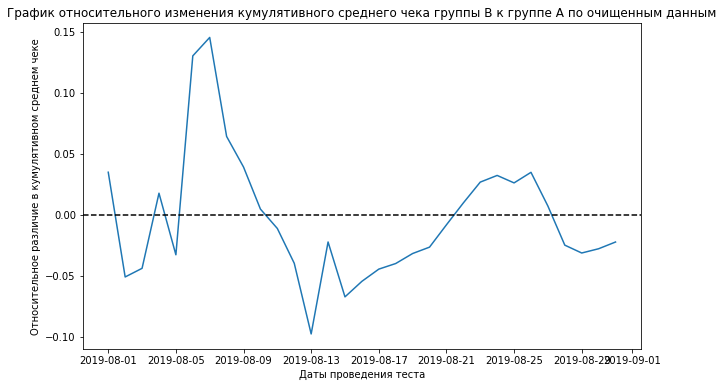

In [56]:
# восстановим все шаги, предпринятые для построения кумулятивных графиков и графиков относительной разницы,
# но в этот раз будем использовать очищенные данные

normal_slice = orders.query('visitor_id not in @abnormal_visitors')

orders_aggregated_2 = (
    dates_groups.apply(lambda x: normal_slice[np.logical_and(normal_slice['date']<=x['date'], normal_slice['group']==x['group'])]
    .agg({'date':'max', 'group':'max', 'transaction_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'}), axis=1)
)

cumulative_data_2 = orders_aggregated_2.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date','group'])

cumulative_data_2 = cumulative_data_2.rename(columns={'transaction_id':'orders', 'visitor_id':'buyers'})

cumulative_revenue_a_2 = cumulative_data_2.query('group=="A"')[['date', 'orders', 'revenue']]

cumulative_revenue_b_2 = cumulative_data_2.query('group=="B"')[['date', 'orders','revenue']]

# построим график относительного изменения кумулятивного среднего чека группы B к группе A

merged_cumulative_revenue_2 = (
    cumulative_revenue_a_2.merge(cumulative_revenue_b_2, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)

plt.figure(figsize=(10, 6))
plt.plot(
    merged_cumulative_revenue_2['date'], (merged_cumulative_revenue_2['revenueB']
    /merged_cumulative_revenue_2['ordersB'])/(merged_cumulative_revenue_2['revenueA']/merged_cumulative_revenue_2['ordersA']) - 1)

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A по очищенным данным')
plt.ylabel('Относительное различие в кумулятивном среднем чеке')
plt.xlabel('Даты проведения теста')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

График относительного изменения кумулятивного среднего чека начинает стабилизироваться, поэтому не похоже, что разница будет значительно увеличиваться. 

# Выводы по проведенному исследованию
<a id='header_19'></a>

**Данный проект был посвящен приоритезации гипотез, предложенных отделом маркетинга, а также анализу запущенного A/B-теста и его результатов. Целью исследования было достижение понимания, существует ли статистически значимый эффект от предложенного в гипотезе нововведения, другими словами - наблюдается ли статистически значимая разница между показателями двух групп теста. Результаты теста позволят компании принять решение, расширять ли нововведение на всех пользователей или нет, поэтому данное исследование также призвано определить необходимость остановки теста или его продолжения**

Исследование проводилось на основе нескольких датасетов. Во-первых, с помощью двух разных методов приоритезации исследовали датафрейм со списком перспективных гипотез, который включал в себя ранее рассчитанные параметры, необходимые для приоритезации проверки гипотез. Во-вторых, мы анализировали данные уже запущенного теста - информацию о количестве пользователей и покупках пользователей из групп A и B.

Исследование проводилось на основе трех датасетов: с гипотезами и параметрами для выявления их приоритетности - hypothesis, с информацией о заказах пользователей из уже запущенного A/B-теста - orders и с информацией о количестве пользователей в каждую из дат проведения теста - visitors.

Размеры датасетов (количество строк и столбцов):

hypothesis: 9 строк и 5 столбцов

orders: 1197 строк и 5 столбцов

visitors: 62 строки и 3 столбца

Знакомство с данными позволило заметить проблемы, которые были устранены на этапе предобработки. 

**Предобработка данных**

На этапе предобработки удалось устранить проблемы, выявленные во время знакомства с данными:
- все названия столбцов приведены к единому стилю
- изменен тип данных в столбцах с дато и временем

Пропуски и дубликаты не были обнаружены.

**Приоритезация гипотез**

Топ-3 наиболее приоритетных гипотез меняется в зависимости от используемого метода приоритезации, что связано с наличием в фреймворке RICE дополнительного параметра reach, который оценивает охват. Так, лидирующая по ICE-score гипотеза №8, предлагающая запуск акции со скидкой на день рождения, получила низкий RICE, так как затрагивает небольшое количество пользователей - именинников.

Чтобы внедряемые изменения были эффективными, советуем начать тестирование одной из следующих наиболее перспективных гипотез:

1) гипотеза №7: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

2) гипотеза №2: Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

3) гипотеза №0: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

**Анализ запущенного A/B-теста**

Выявление различий в группах теста осуществлялось с помощью анализа двух метрик: конверсии пользователей в заказы, то есть среднего количества заказов на пользователя и среднего чека.

Для оценки резултатов запущенного A/B-теста, а также достоверности его результатов и определения, достигнута ли статистически значимая разница по интересующим нас показателям у разных групп теста были предприняты следующие действия:

- были построены кумулятивные графики выручки, среднего количества заказов, а также среднего чека

Графики позволили заподозрить наличие в данных аномалий - пользователей, демонстрирующих нестандартную активность - совершающих очень большое количество заказов и очень дорогие заказы. Поэтому было решено провести дополнительную проверку на наличие выбросов и аномалий в данных, чтобы исключить их влияние на результаты теста.

- были построены графики относительной разницы среднего количества заказов и среднего чека

Было установлено, что к концу теста кумулятивный средний чек группы В был выше аналогичного показателя группы А примерно на 26%
Бало установлено, что в концу теста кумулятивная средняя конверсия у группы В была выше аналогичного показателя группы А приблизительно на 14%

- был проведен статистический тест с помощью критерия Манна-Уитни по "сырым данным" для определения статистически значимой разницы между сегментами теста: сравнивались среднее количество заказов и средний чек. Для этого были сформулированы пары нулевой и альтернативной гипотез.

*Поиск статистически значимой разницы в конверсиях:*

• H0: Среднее количество заказов в разных группах теста равно

• H1: Среднее количество заказов в группах А и В отличается

*Поиск статистически значимой разницы в среднем чеке:*

• H0: Средний чек в разных группах теста одинаков

• H1: Средний чек в группах А и В отличается

**Статистические тесты, запущенные на основе "сырых" данных позволили установить:**

• *наличие статистически значимого различия в конверсиях разных сегментов теста*: p_value = 0,017, то есть меньше выбранного уровня статистической значимости в 0,05%, что позволило отвергнуть нулевую гипотезу. Вероятнее всего, различия между группами в конверсии присутствуют.
Средняя конверсия группы В лучше примерно на 14% относительно группы А.

• *отсутствие статистически значимого различия в среднем чеке разных сегментов теста*: p_value = 0,729, что значительно превышает уровень стат.значимости, а значит, не позволяет отвергуть нулевую гипотезу. 
При этом средний чек группы В выше в относительном выражении примерно на 26%.

**Обработка выбросов и аномалий в данных**

*Было проведено исследование структуры данных о количестве заказов пользователей и стоимости заказов, с целью получения представления о "нормальных" значениях*

Построенные точечные диаграммы и найденные 99 и 95 процентили по количеству заказов и стоимости заказа помогли найти верхнюю границу, по которой была проведена "очистка" данных. Не более 5% от всех пользователей оформляли больше чем 2 заказа, 1% пользователей оформляли заказ более 4 раз. Не более 5% от всех заказов имеют стоимость больше чем 28 000 рублей, 1% заказов - более 58 233 рублей. 

Мы исключили из исследования пользователей, сделавших более 2 заказов и заказы стоимостью превышающие 28000 рублей. 

Также во время подготовки данных к проведения статистического теста, было обнаружено, что в данных есть неожиданная проблема - 58 пользователей попали сразу в обе группы теста. Их было решено также исключить, чтобы они не оказали влияния на достоверность теста. 

Всего во время "очистки" данных было исключено 113 пользователей.

**Статистические тесты, запущенные на основе "очищенных" данных позволили установить**

• *наличие статистически значимой разницы в конверсиях разных сегментов*: p_value = 0,009, заметно меньше выбранного уровня статистической значимости в 0,05%, что позволило отвергнуть нулевую гипотезу. 
Значимое различие было найдено, как на основе "сырых" данных, так и по "очищенным"
Средняя конверсия группы В по очищенным данным лучше примерно на 19% относительно группы А.

• *отсутствие статистически значимого различия в среднем чеке разных сегментов теста*: p_value = 0,762, что также, как и в случае с "сырыми" данными, значительно превышает уровень стат.значимости, а значит, не позволяет отвергуть нулевую гипотезу. 
При этом отсносительная разница сегментов изменилась - по очищенным данным средний чек группы В хуже на 0,02% относительно группы А.


 # Рекомендации по результатам A-B теста
 <a id='header_20'></a>

В целом, на основании "сырых" и "чистых" данных мы видим статистически значимую разницу в конверсии и отсутствие значимой разницы в среднем чеке. При этом сегмент В имеет подтвержденное значимое преимущество по конверсии, однако, в случае со средним чеком по "чистым данным" относительная разница не в пользу группы В. 

Перед принятием решения о продолжении и приостановке A/B-теста необходимо еще раз ознакомиться с заранее рассчитанным размером выборки. Если мы имеем достаточно наблюдений относительно рассчитанного заранее количества и при этом, график относительной разницы стабилизировался, то следует остановить тест.

В нашем случае мы можем зафиксировать наличие разницы между группами с оговоркой, что разница наблюдается лишь в одной целевой метрике - конверсии в заказ. Проведенный статистический тест позволил отвергнуть нулевую гипотезу о равенстве конверсий, так как вероятность случайно получить такую разницу очень низкая (p_value = 0,009). А вот в среднем чеке не удалось обнаружить и подтвердить различия (p_value = 0,762): вряд ли при продолжении теста p_value снизится до уровня 0.05 или ниже. 

**Таким образом, мы можем рекомендовать завершение теста. Группа В лучше: основная целевая метрика - конверсия, показала устойчивое улучшение, в то время как вторая метрика - средний чек, не ухудшилась. Значит, изменение затронуло количество заказов, но не их размер.**
